# Data Science Project: Predicting Usage of a Video Game Research Server

## Introduction

This project investigated whether a player's level of experience can be predicted by their age and the amount of hours they played. A Minecraft server was set up by a research group in the Department of Computer Science at UBC, in order to record how players navigate the world. However, in order to efficiently allocate their resources such as server hardware, they must target players that are most likely to provide a large amount of data. This project aims to discover  ---- so that they can be targetted in their recruiting efforts, in order to increase the data collected. 

### Data Description

In order to investigate the question, the players.csv data set will be used. This file includes information of the unique players and some data about each player. This file has 7 variables and 196 observation. Each observation represents a player and some of their characteristics. The variables include,

- experience: the player's experience level; Beginner, Amateur, Regular, Pro, and Veteran.
- subscribe: whether or not the player would be interested in subscribing to a game-related newsletter
- hashedEmail: the player's email that has been processed to encrypt it
- played_hours: the amount of hours the player played on the server
- name: the name of the player
- gender: the gender of the player
- Age: the age of the player

Amongst this variables, there are 3 variables that are important to our data analysis: experience, played_hours, and Age. So, in the data cleaning/wrangling step, we will be removing all the other variables.  

There are a couple issues I see with the data. By using the group_by and summarise function, I can see how many players of each experience there are. There seems to be class imbalance amongst the levels, so I will add an oversampling step, using the step_upsample function from the themis R package.

Below, are cleaning and wrangling steps, in order to make the data fit for the analysis. 

## Methods and Results
describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
- loads data
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- Use our visualization best practices to make high-quality plots (make sure to include labels, titles, units of measurement, etc)
- Explain any insights you gain from these plots that are relevant to address your question
performs the data analysis. For your analysis, you should think about and provide a brief explanation of the following questions:
- Why is this method appropriate?
- Which assumptions are required, if any, to apply the method selected?
- What are the potential limitations or weaknesses of the method selected?
- How did you compare and select the model?
Note: you should also think about the following:
- How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits?
- What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation?
- creates a visualization of the analysis 
note: all figures should have a figure number and a legend

In [8]:
# Run this cell before continuing
library(tidyverse)
library(tidymodels)
library(themis)

In [9]:
# Loading the player data set
player_data <- read_csv("data/players.csv")

head(player_data) # to view the first few rows

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [10]:
Looking at the variables, ---- using the select function, called wrangled_player_data

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected symbol
1: Looking at
            ^


In [64]:
player_wrangle <- player_data |>
  select(experience, played_hours, Age) |>
  mutate(
    experience = as_factor(experience),
    played_hours = if_else(is.na(played_hours), mean(played_hours, na.rm = TRUE), played_hours),
    Age = if_else(is.na(Age), mean(Age, na.rm = TRUE), Age)
  )
head(player_wrangle)

experience,played_hours,Age
<fct>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
Amateur,0.7,21
Regular,0.1,21
Amateur,0.0,17


In [65]:
# Seeing how many of each experience level there is
exp_count <- player_wrangle |>
                group_by(experience) |>
                summarise(count = n())
exp_count

experience,count
<fct>,<int>
Pro,14
Veteran,48
Amateur,63
Regular,36
Beginner,35


From this summary, we can see that there is class imbalance; the Amateur level is much more common than Pro. Before we balance the classes, let's split the data set into training and testing, and we will only balance the training set.

In [67]:
# run this cell to split the data
player_split <- initial_split(player_wrangle, prop = 0.70, strata = experience)
player_training <- training(player_split)
player_testing <- testing(player_split)

# player_testing %>%
#   filter(is.na(played_hours) | is.na(Age)) %>%
#   nrow()

In [68]:
# run this cell to balance the classes
player_recipe <- recipe(experience ~ played_hours + Age, data = player_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(experience, over_ratio = 1, skip = TRUE)

# Let's see if it worked
player_upsampled <- player_recipe |>
                        prep() |>
                        bake(new_data = NULL) |>
                        group_by(experience) |>
                        summarise(n = n())
player_upsampled

experience,n
<fct>,<int>
Pro,44
Veteran,44
Amateur,44
Regular,44
Beginner,44


In [69]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
                set_engine("kknn") |>
                set_mode("classification")

knn_fit <- workflow() |>
            add_recipe(player_recipe) |>
            add_model(knn_spec) |>
            fit(data = player_training)

player_predict <- knn_fit |>
                    predict(player_testing) # |>
                    # bind_cols(player_testing)
nrow(player_predict)
nrow(player_testing)

# predict <- player_predict |>
#   metrics(truth = experience, estimate = .pred_class) |>
#   filter(.metric == "accuracy")
# predict

[1] 61

[1] 61

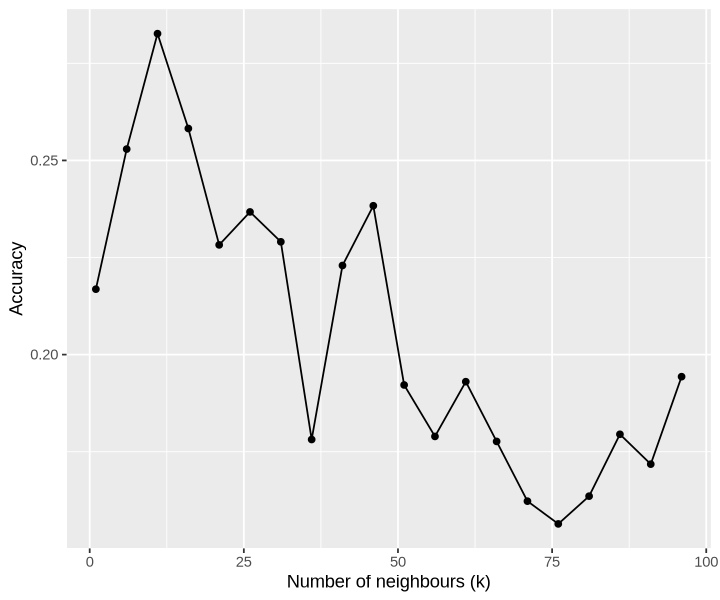

In [70]:
set.seed(1234)
options(repr.plot.height = 5, repr.plot.width = 6)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

training_vfold <- vfold_cv(player_training, v = 5, strata = experience)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
                add_recipe(player_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = training_vfold, grid = k_vals)

accuracies <- knn_results |>
                collect_metrics() |>
                filter(.metric == "accuracy")

cross_val_plot <- accuracies |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of neighbours (k)", y = "Accuracy")
cross_val_plot